## VAE Encode-Decode_Classify

In [1]:
import numpy as np
import pandas as pd

%pwd

'/home/chanapa/working_dir/eeg_digitsFABLA'

### 1. Loading Data

#### Load CSV

In [2]:
df = pd.read_csv("data/raw_data/raw_eeg_0.5s/p5.csv")
df.head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Marker
0,411.682,54952.211,39326.645,63368.984,40366.020,42082.410,60855.262,7739.001,40935.812,-2200.082,43950.125,6032.713,32013.062,40150.684,35738.809,78066.734,65474.184,0
1,411.683,54946.578,39321.793,63363.820,40359.496,42082.344,60852.246,7710.056,40912.230,-2202.273,43965.168,6052.629,31879.578,40058.461,35669.832,78010.336,65291.211,0
2,411.684,54939.559,39313.297,63361.316,40349.547,42084.512,60853.520,7703.529,40918.758,-2186.247,43935.191,6020.599,32011.029,40142.168,35708.590,78044.203,65430.887,0
3,411.685,54972.617,39342.805,63403.562,40367.160,42099.289,60858.234,7740.990,40937.621,-2198.965,43970.508,6061.078,31939.078,40093.867,35712.789,78051.133,65372.641,0
4,411.686,54933.504,39320.742,63343.277,40335.398,42080.758,60848.445,7672.147,40888.875,-2202.340,43950.973,6023.661,31911.160,40074.242,35649.559,78002.266,65310.547,0


In [3]:
df = df.drop(["timestamps"], axis=1)

In [4]:
df.columns = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'C3', 'Cz', 'C4', 'T5', 'P3', 'P4',
           'T6', 'POz', 'O1', 'O2', 'Marker']   #channels named according to how we plug our eeg device
df.head()

,Fp1,Fp2,F7,F3,F4,F8,C3,Cz,C4,T5,P3,P4,T6,POz,O1,O2,Marker
0,54952.211,39326.645,63368.984,40366.020,42082.410,60855.262,7739.001,40935.812,-2200.082,43950.125,6032.713,32013.062,40150.684,35738.809,78066.734,65474.184,0
1,54946.578,39321.793,63363.820,40359.496,42082.344,60852.246,7710.056,40912.230,-2202.273,43965.168,6052.629,31879.578,40058.461,35669.832,78010.336,65291.211,0
2,54939.559,39313.297,63361.316,40349.547,42084.512,60853.520,7703.529,40918.758,-2186.247,43935.191,6020.599,32011.029,40142.168,35708.590,78044.203,65430.887,0
3,54972.617,39342.805,63403.562,40367.160,42099.289,60858.234,7740.990,40937.621,-2198.965,43970.508,6061.078,31939.078,40093.867,35712.789,78051.133,65372.641,0
4,54933.504,39320.742,63343.277,40335.398,42080.758,60848.445,7672.147,40888.875,-2202.340,43950.973,6023.661,31911.160,40074.242,35649.559,78002.266,65310.547,0


In [5]:
# print(df['Marker'].unique())

In [6]:
#use numpy as another view of the pandas columns for faster operation
marker_np = df['Marker'].values

for idx, marker in enumerate(marker_np):
    if "Fixation" in marker:
        marker_np[idx] = 0
    elif "," in marker:
        #we reserved 0 for no event, so class 0-9 will be represented as 1-10 instead
        marker_np[idx] = int(marker.split(",")[-1]) + 1   
    else:
        marker_np[idx] = 0
    
#check whether df['Marker'] changed according to np
print(df['Marker'].unique())

[0 5 2 6 4 7 3 1 9 8 10]


In [7]:
print(df.groupby('Marker').nunique())
# 50 trial / each stimuli 

          Fp1    Fp2     F7     F3     F4     F8     C3     Cz     C4     T5  \
Marker                                                                         
0       54061  53112  62746  65765  55473  61988  63213  65060  58282  61540   
1          49     50     50     50     50     50     50     50     50     50   
2          50     50     50     50     50     50     50     50     50     50   
3          50     50     50     50     50     50     50     50     50     50   
4          50     50     50     50     50     50     50     50     50     50   
5          50     50     50     50     50     50     50     50     50     50   
6          50     50     50     50     50     50     50     50     50     50   
7          50     50     50     50     50     50     50     50     50     50   
8          50     50     50     50     50     50     50     50     50     50   
9          50     50     50     50     50     50     50     50     50     50   
10         50     50     50     50     5

### 2. Artifact Removal

In [8]:
import mne
from mne import create_info
from mne.io import RawArray

def df_to_raw(df):
    sfreq = 125
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

Creating RawArray with float64 data, n_channels=17, n_times=74004
    Range : 0 ... 74003 =      0.000 ...   592.024 secs
Ready.
Effective window size : 16.384 (s)


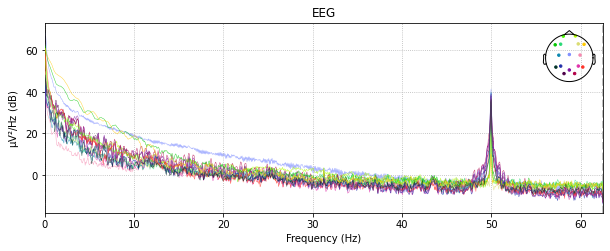

In [9]:
raw = df_to_raw(df)

#### 1. Power line noise

In [10]:
raw.notch_filter(50, filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 825 samples (6.600 sec)



<RawArray | 17 x 74004 (592.0 s), ~9.6 MB, data loaded>

Effective window size : 16.384 (s)


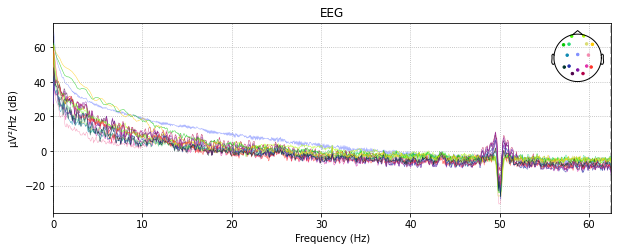

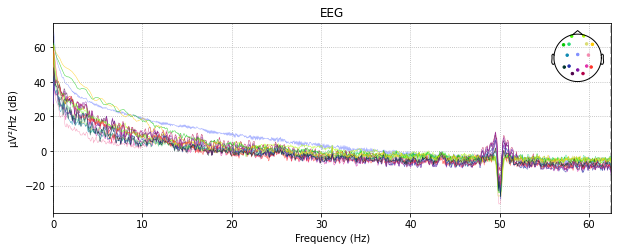

In [11]:
raw.plot_psd()

#### 2. Slow drift

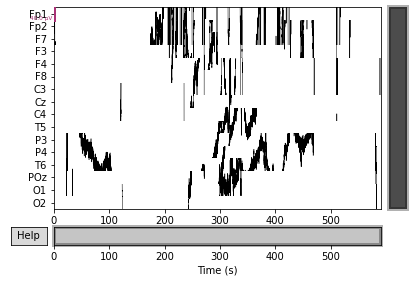

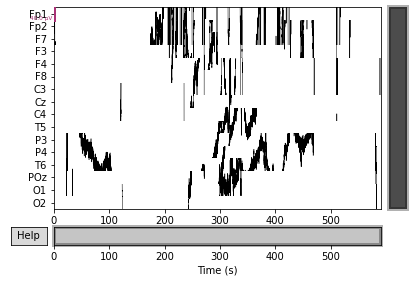

In [12]:
eeg_channels = mne.pick_types(raw.info, eeg=True)
raw.plot(duration=900, order=eeg_channels)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4125 samples (33.000 sec)



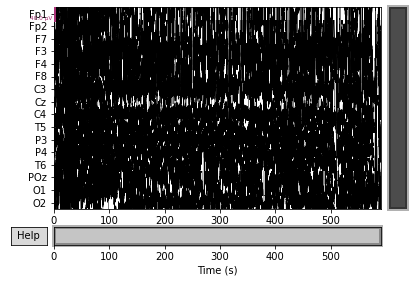

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 2063 samples (16.504 sec)



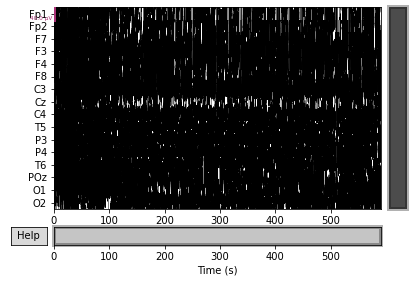

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)



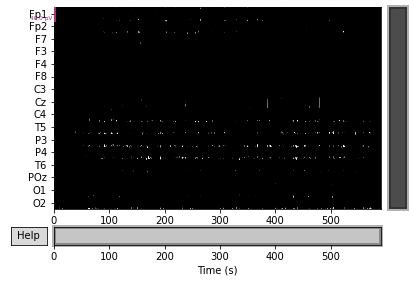

In [13]:
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
    fig = raw_highpass.plot(duration=900, order=eeg_channels)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Effective window size : 16.384 (s)


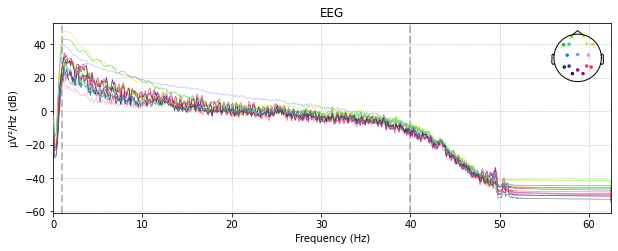

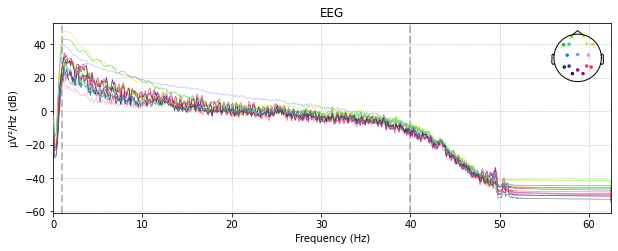

In [14]:
# Filter frequency higher than 1 Hz seems to be most efficient at removing slow drifts
raw.filter(1, 40, method='iir')

raw.plot_psd()

### 3. Epoching

In [15]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most frequency in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [16]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'0': 1, '1' : 2, '2': 3, '3':4, '4':5, '5':6, '6':7, '7':8, '8':9, '9':10}
tmin = 0
tmax = 0.5 #0.5 seconds
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)
#print(epochs.get_data())

500 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10]
sample drop %:  0.0


In [17]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)

(500, 16, 63)
(500,)


In [18]:
np.save('saved_samples/X_p2.npy', X)

### 3. Define Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Encoder and Decoder VAE

In [20]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conven1 = nn.Sequential(nn.Conv1d(16, 32, kernel_size=(1,5), stride=(1,1), padding=(0,0)), nn.ReLU())
        self.conven2 = nn.Sequential(nn.Conv1d(32, 64, kernel_size=(1,5), stride=(1,1), padding=(0,0)), nn.ReLU())
        
        self.fcen1 = nn.Sequential(nn.Linear(3520,2048), nn.ReLU(), nn.Dropout(0.2))
        self.fcen2 = nn.Sequential(nn.Linear(2048,1024), nn.ReLU())
        self.fcen3 = nn.Sequential(nn.Linear(1024,512), nn.ReLU(), nn.Dropout(0.2))
        self.fcen4 = nn.Sequential(nn.Linear(512,256), nn.ReLU())
        self.fcen5 = nn.Sequential(nn.Linear(256,128), nn.ReLU(), nn.Dropout(0.2))
        
        self.fcenmu = nn.Sequential(nn.Linear(128,32))
        self.fcenvar = nn.Sequential(nn.Linear(128,32))
        
        self.fcde1 = nn.Sequential(nn.Linear(32,128), nn.ReLU())
        self.fcde2 = nn.Sequential(nn.Linear(128,256), nn.ReLU(), nn.Dropout(0.2))
        self.fcde3 = nn.Sequential(nn.Linear(256,512), nn.ReLU())
        self.fcde4 = nn.Sequential(nn.Linear(512,1024), nn.ReLU(), nn.Dropout(0.2))
        self.fcde5 = nn.Sequential(nn.Linear(1024,2048), nn.ReLU())
        self.fcde6 = nn.Sequential(nn.Linear(2048,3520), nn.ReLU(), nn.Dropout(0.2))

        self.convde1 = nn.Sequential(nn.ConvTranspose1d(64, 32, kernel_size=(1,5), stride=(1,1), padding=(0,0)), nn.ReLU())
        self.convde2 = nn.Sequential(nn.ConvTranspose1d(32, 16, kernel_size=(1,5), stride=(1,1), padding=(0,0)), nn.ReLU())
           
    def encode(self, x):
        x = self.conven1(x)
        x = self.conven2(x)
        x = x.flatten(start_dim = 1)
        x = self.fcen1(x)
        x = self.fcen2(x)
        x = self.fcen3(x)
        x = self.fcen4(x)
        x = self.fcen5(x)
        mu = self.fcenmu(x)
        log_var = self.fcenvar(x)
        return mu, log_var
        
    def reparameterize(self, mu, log_var): # from Zscore = (Xi - mu) / sd
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample
    
    def decode(self, sample):
        x_re = self.fcde1(sample)
        x_re = self.fcde2(x_re)
        x_re = self.fcde3(x_re)
        x_re = self.fcde4(x_re)
        x_re = self.fcde5(x_re)
        x_re = self.fcde6(x_re)
        x_re = x_re.reshape(x_re.shape[0], 64, 1, -1)
#         print(x_re.shape)
        x_re = self.convde1(x_re)
#         print(x_re.shape)
        x_re = self.convde2(x_re)
#         print(x_re.shape)
        return x_re
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        sample = self.reparameterize(mu, log_var)
#         print(sample.shape)
        x_re = self.decode(sample)
        return x_re, mu, log_var
    
    def feat_ext(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return z

In [21]:
testvae = VAE()
datatest = torch.Tensor(X).float()
datatest = datatest.reshape(500,16,1,63)
test = testvae(datatest)

In [22]:
#LSTM
model_conv1d_VAE = VAE()
model_conv1d_VAE = model_conv1d_VAE.float()

models = [model_conv1d_VAE]

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model VAE has 20,038,032 trainable parameters


In [24]:
import torch.optim as optim

learning_rate = 0.01

optimizer = optim.Adam(model.parameters())
# criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cpu


In [26]:
for model in models:
    model = model.to(device)
# criterion = criterion.to(device)

In [27]:
torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)

print(np.unique(torch_y))

[ 1  2  3  4  5  6  7  8  9 10]


In [28]:
print("Original X: ", torch_X.size())

Original X:  torch.Size([500, 16, 63])


In [29]:
torch_X_reshaped = torch_X.reshape(500,16,1,63)
print("Converted X: ", torch_X_reshaped.size())

Converted X:  torch.Size([500, 16, 1, 63])


## DEFINE DATA LOADER FOR VAE

In [30]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_X_reshaped) # reconstruction use the input data as y !!

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = int(torch_X_reshaped.size()[0] * 0.2)
test_size = int(torch_X_reshaped.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU


# Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                            pin_memory=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                            pin_memory=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                           pin_memory=True)

In [31]:
def train(model, iterator, optimizer):
    epoch_loss = 0
    
    model.train()
    
    for batch, batch_recon in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        batch_recon = batch_recon.to(device).float()
        
        #Forward pass
        x_recon, mu, log_var = model(batch.float())
#         x_recon = x_recon.float()
#         mu = mu.float()
#         log_var = log_var.float()
        
        reconst_loss = F.mse_loss(x_recon.float(), batch_recon, size_average = True)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator):
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, batch_recon in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            batch_recon = batch_recon.to(device)

            x_recon, mu, log_var = model(batch.float())
            reconst_loss = F.mse_loss(x_recon.float(), batch_recon, size_average = True)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
N_EPOCHS = 50

best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []


for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer)
        valid_loss = evaluate(model, valid_iterator)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
#             print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), 'models/VAEdeen31.pth.tar')
            best_model_index = i

Training VAE


/home/chanapa/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 0.370
	 Val. Loss: 0.012
Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 0.266
	 Val. Loss: 0.007
Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 0.271
	 Val. Loss: 0.027
Epoch: 40 | Epoch Time: 0m 1s
	Train Loss: 0.250
	 Val. Loss: 0.010
Epoch: 50 | Epoch Time: 0m 1s
	Train Loss: 0.236
	 Val. Loss: 0.000


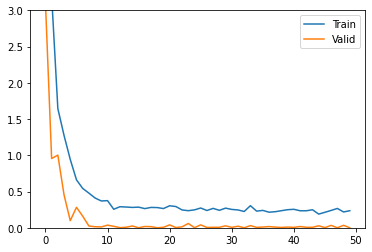

In [35]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label = 'Train')
plt.plot(valid_loss_list, label = 'Valid')
plt.ylim(0,3)
plt.legend()

In [36]:
models[best_model_index].load_state_dict(torch.load('models/VAEdeen31.pth.tar'))

test_loss = evaluate(models[best_model_index], test_iterator)
print(f'Test Loss: {test_loss:}')

Test Loss: 0.00022864377631937876


## Use the trained VAE as feature extractor

In [37]:
model.eval() 

with torch.no_grad():
    Zs = model.feat_ext(torch_X_reshaped.float())
    recon = model.decode(Zs)

print(Zs.shape)
print(recon.shape)

torch.Size([500, 32])
torch.Size([500, 16, 1, 63])


## Save sample from the distribution and the labels

In [38]:
np.save('saved_samples/Z_p2.npy', Zs)
np.save('saved_samples/y_p2.npy', y)

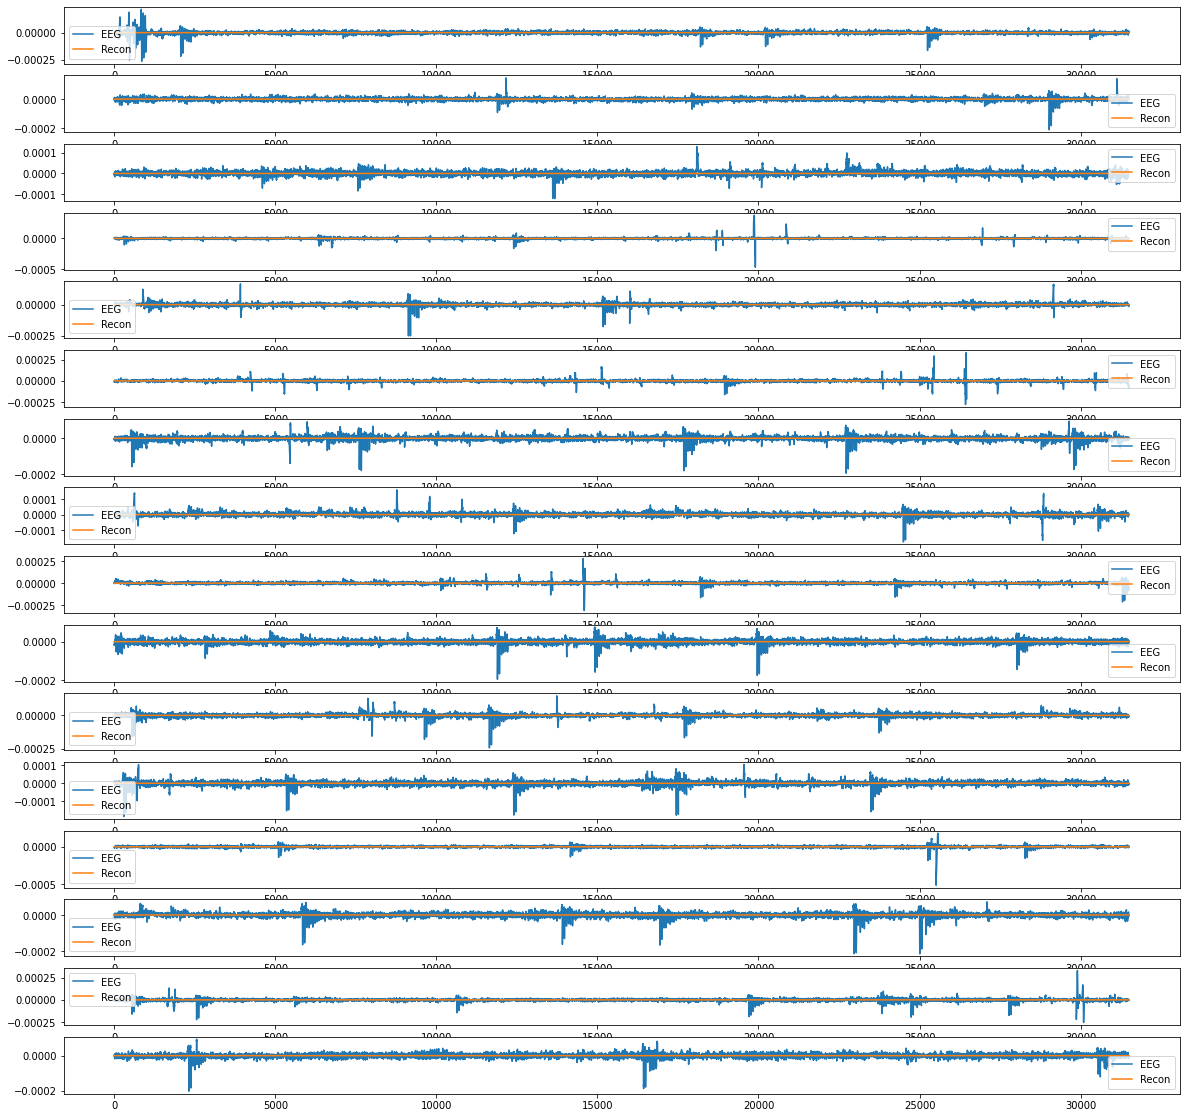

In [39]:
# Plot one stimuli
data_plot = torch_X_reshaped.reshape(16,-1)
recon_plot = recon.reshape((data_plot.shape)).cpu()

figure, ax = plt.subplots(16,1,figsize=(20,20))
for i in range(0,16):
    ax[i].plot(data_plot[i], label="EEG")
    ax[i].plot(recon_plot[i], label="Recon")
    ax[i].legend()

In [40]:
print(recon.max())
print(recon.min())

tensor(0.)
tensor(0.)


All reconstructed EEG has value of 0.00 in all channel and all stimuli

In [41]:
import gc
for model in models:
    del model
    gc.collect()
    torch.cuda.empty_cache()